In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/INT20H/final_version

/content/drive/MyDrive/INT20H/final_version


In [27]:
!pip install scikit-optimize
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 KB 3.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [30]:
import skopt
from skopt.space import Real, Categorical, Integer

import optuna
from optuna.visualization import plot_intermediate_values

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, KFold, cross_val_score, cross_validate


import warnings
warnings.filterwarnings('ignore')

In [29]:
optuna.logging.set_verbosity(optuna.logging.CRITICAL)

In [93]:
import pandas as pd
import numpy as np

def merge(orders):
    nodes = pd.read_csv("data/nodes.csv")
    mean_speed_by_hour = pd.read_csv("data/mean_speed_by_hour_concat.csv", )
    merged = pd.merge(nodes, orders, how='left', on='Id')
    merged = pd.merge(merged, mean_speed_by_hour, how='left', on='Id')
    merged = merged.dropna()
    
    return merged
    
train_orders = pd.read_csv("data/orders.csv")
test_orders = pd.read_csv("data/test.csv")

train_df = merge(train_orders)
test_df =  merge(test_orders)


#### Weather

In [94]:
import re

wearher_df = pd.read_excel('data/weather.xlsx')

cols_to_process = ['Temperature', 'Dew Point', 'Humidity', 'Wind Speed', 'Wind Gust', 'Pressure', 'Precip.']

def process_numerical(x):
    return re.compile(r'(\d+(?:\.\d+)?)').findall(x)[0]

for col in cols_to_process:
    wearher_df[col] = wearher_df[col].apply(lambda x: process_numerical(x)).astype(float)

    
wearher_df['isWindy'] = wearher_df['Condition'].apply(lambda x: 1 if len(x.split('/'))==2 else 0)
wearher_df['Condition'] = wearher_df['Condition'].apply(lambda x: x.split('/')[-1] if len(x.split('/'))==2 else x)

wearher_df['time_h_m'] = pd.to_datetime(wearher_df['Time']).apply(lambda x: x.strftime("%H:%M"))
wearher_df.drop('Time', axis=1, inplace=True)

#### Merge weather

In [95]:
def merge_weather(merged):
    merged['time_h_m'] = pd.to_datetime(pd.to_datetime(merged['running_time'])
                                       .apply(lambda x: x.strftime("%H:%M")))
    wearher_df['time_h_m'] = pd.to_datetime(wearher_df['time_h_m'])

    merged.sort_values('time_h_m', inplace=True)
    wearher_df.sort_values('time_h_m', inplace=True)

    merged = pd.merge_asof(merged, wearher_df, on='time_h_m')
    merged.drop('time_h_m', axis=1, inplace=True)

    wind = pd.get_dummies(merged['Wind'])

    merged.drop(['Wind'], axis=1, inplace=True)

    condition = pd.get_dummies(merged['Condition'])

    merged.drop(['Condition'], axis=1, inplace=True)

    merged = pd.concat([merged, wind, condition],axis=1)
    
    return merged

train_df = merge_weather(train_df)
test_df =  merge_weather(test_df)

In [96]:
def time_preprocess(df):
    df['running_time'] = pd.to_datetime(df['running_time'])
    df['seconds'] = df['running_time'].apply(lambda x: x.hour * 3600 + x.minute * 60 + x.second)

    df['mean_time'] = df['route_distance_km']/df['speed']
    
    return df

train_df = time_preprocess(train_df)
test_df =  time_preprocess(test_df)


In [97]:
train_df

,Id,node_start,node_finish,distance,speed,running_time,completed_time,route_distance_km,delta_time,mean_speed,...,NNW,Windy,Fair,Fog,Heavy Snow Shower,Light Snow,Light Snow Shower,Snow Shower,seconds,mean_time
0,1232212655921391683,1751397875,2143061093,415.884324,52.0,2022-01-24 00:30:04,2022-01-24 00:40:54,8.023,650.0,40.707335,...,0,0,1,0,0,0,0,0,1804,0.154288
1,1232212655921391683,2132008186,2132008185,127.838766,59.0,2022-01-24 00:30:04,2022-01-24 00:40:54,8.023,650.0,40.707335,...,0,0,1,0,0,0,0,0,1804,0.135983
2,1232212655921391683,2132008195,2132008186,130.516355,56.0,2022-01-24 00:30:04,2022-01-24 00:40:54,8.023,650.0,40.707335,...,0,0,1,0,0,0,0,0,1804,0.143268
3,1232212655921391683,2143061084,1751397864,117.904174,34.0,2022-01-24 00:30:04,2022-01-24 00:40:54,8.023,650.0,40.707335,...,0,0,1,0,0,0,0,0,1804,0.235971
4,1232212655921391683,2143061093,965088641,12.569506,34.0,2022-01-24 00:30:04,2022-01-24 00:40:54,8.023,650.0,40.707335,...,0,0,1,0,0,0,0,0,1804,0.235971
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
398038,-4036390670371710012,8952419261,8952419260,28.737236,51.0,2022-01-24 23:55:59,2022-01-25 00:05:48,4.853,589.0,37.658512,...,1,0,0,0,0,1,0,0,86159,0.095157
398039,-4036390670371710012,8952419262,8952419261,19.655378,37.0,2022-01-24 23:55:59,2022-01-25 00:05:48,4.853,589.0,37.658512,...,1,0,0,0,0,1,0,0,86159,0.131162
398040,4378890784988522255,321367936,4773741543,47.074879,33.0,2022-01-24 23:55:48,2022-01-25 00:04:27,4.739,519.0,37.628414,...,1,0,0,0,0,1,0,0,86148,0.143606
398041,4378890784988522255,321368151,290664073,26.382740,28.0,2022-01-24 23:55:48,2022-01-25 00:04:27,4.739,519.0,37.628414,...,1,0,0,0,0,1,0,0,86148,0.169250


In [98]:

def agregate_df(df):
    agregated_df = pd.DataFrame()

    gpby = df.groupby('Id')

    for name in df.columns:
        if name == 'distance':
            agregated_df[name] = gpby[name].sum()
        elif name in ['node_start','node_finish','running_time','completed_time']:
            pass
        else:
            agregated_df[name] = gpby[name].mean()
    
    agregated_df['node_list'] = gpby['node_start'].apply(list)+gpby['node_finish'].apply(list)
            
    for i in agregated_df.index.tolist():
        agregated_df.at[i, 'node_list'] = list(set(agregated_df['node_list'][i]))
    
    try:
        df = df.drop(['Id','node_start','node_finish','running_time','completed_time'],axis=1)
    except:
        df = df.drop(['Id', 'node_start','node_finish','running_time'],axis=1)
    
    return agregated_df

train_df = agregate_df(train_df)
test_df =  agregate_df(test_df)

In [99]:
train_df

,Id,distance,speed,route_distance_km,delta_time,mean_speed,Temperature,Dew Point,Humidity,Wind Speed,...,Windy,Fair,Fog,Heavy Snow Shower,Light Snow,Light Snow Shower,Snow Shower,seconds,mean_time,node_list
Id,,,,,,,,,,,,,,,,,,,,,
-9220688251826578095,-9.220688e+18,3002.769444,25.987952,3.179,469.0,33.590235,23.0,23.0,100.0,18.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,84175.0,0.134274,"[352681475, 3559438863, 1920042005, 352681497,..."
-9218029690111550526,-9.218030e+18,5629.671654,29.945455,6.137,688.0,30.910917,21.0,21.0,100.0,18.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,75310.0,0.221409,"[1570776576, 1366816272, 321373221, 2134828078..."
-9203204462098983368,-9.203204e+18,5598.776895,33.336538,6.312,683.0,31.221039,23.0,21.0,93.0,18.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,81517.0,0.208891,"[4787206656, 4787206660, 5209082374, 895239015..."
-9183832189489697758,-9.183832e+18,5041.412407,35.449612,6.379,885.0,30.867370,23.0,21.0,93.0,18.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,80425.0,0.198274,"[4416208903, 27128842, 4768391697, 2377239575,..."
-9182793427449706037,-9.182793e+18,2428.830059,24.269231,2.551,612.0,27.819898,23.0,23.0,100.0,20.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,62748.0,0.124448,"[1264113187, 3400585770, 3400585771, 399645598..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9210081165830935160,9.210081e+18,5643.386411,33.754658,5.520,753.0,31.940148,23.0,23.0,100.0,18.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,82685.0,0.178385,"[317288454, 278078475, 317288461, 3358702097, ..."
9210110364218727646,9.210110e+18,3008.850367,30.095960,3.146,462.0,30.954228,21.0,21.0,100.0,18.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,74221.0,0.110084,"[27128838, 4416208903, 317193222, 278078475, 2..."
9210371713303339999,9.210372e+18,4435.537379,40.777778,4.038,607.0,32.578498,27.0,23.0,86.0,20.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,19683.0,0.107184,"[710147595, 702371912, 1988289117, 2324928110,..."


# OSM

In [100]:
import pandas as pd
import ast

def add_osm(df):
    osm_fin = pd.read_csv('data/osm.csv',index_col=0)

    # shop replace travel_agency 2 yes

    del_list = [
    'opening_hours', 'name:en', 'mapillary','name:uk','addr:postcode','addr:city','traffic_sign:forward','motor_vehicle:conditional',
    'name:ru','addr:housenumber','local_ref','man_made','addr:street','natural','website','source','water_source','description','cuisine','power',
    'ref_name','phone','old_name','name:be', 'addr:state','name','ref','operator','maxheight']

    osm_fin = osm_fin[[x for x in list(osm_fin) if x not in del_list]]

    df_dummies = pd.get_dummies(osm_fin, columns=list(osm_fin)[1:])
    df_dummies = df_dummies.drop(columns=[s for s in list(df_dummies) if "_0" in s])
    df_dummies = df_dummies.drop(columns=[s for s in list(df_dummies) if "_no" in s])

    for index in list(df_dummies)[1:]:
        df[index] = 0

    slice_list = []

    for index in range(len(df)):
        ans = df_dummies[df_dummies.id.isin(df.node_list.values[index])].sum().values.tolist()[1:]
        slice_list.append(ans)

    for count, index in enumerate(df.index.tolist()):
        df.loc[index, list(df_dummies)[1:]] = slice_list[count]

    df = df.drop(columns=['node_list'])
    return df

train_df = add_osm(train_df)
test_df =  add_osm(test_df)

In [101]:
train_df.drop(['Id'],axis=1, inplace=True)
test_df.drop(['Id'],axis=1, inplace=True)

train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

y_train = np.array(train_df['delta_time']).reshape(-1, 1)
X_train = train_df.drop(['delta_time'], axis=1)

# y_test = np.array(test_df['delta_time']).reshape(-1, 1)
X_test = test_df

In [102]:
from sklearn.preprocessing import StandardScaler, RobustScaler

# X_scaler = StandardScaler()
X_scaler = RobustScaler()
# y_scaler = StandardScaler()
X_train_scaled = X_scaler.fit_transform(X_train)

X_test_scaled = X_scaler.transform(X_test)
# y = y_scaler.fit_transform(y)

In [103]:
X_train.shape, X_train_scaled.shape

((5000, 118), (5000, 118))

In [104]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from xgboost import XGBRegressor

params={'max_depth': 3,
        'min_child_weight': 4,
        'gamma': 0.15,
        'colsample_bytree': 0.85,
        'subsample': 1.0}

model = XGBRegressor(**params)

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X_train_scaled, y_train, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
# force scores to be positive
scores = np.abs(scores)

# mean_score = y_scaler.inverse_transform(scores.mean().reshape(1, -1))[0][0]
mean_score = scores.mean()

print(f'Mean RMSE: {mean_score}')


Mean RMSE: 120.49735331905542


In [ ]:
124.3322115294206

#### Hyperparam Optimisation

In [33]:
def cv_rmse(model, X, y, kfolds=cv):
    return np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kfolds))

def display_cv_scores(rmse_, mae_, r2_):
    print(f'RMSE CV: {rmse_}  \nMean RMSE: {round(rmse_.mean(),5)} \nStd RMSE: {round(rmse_.std(),5)}')

##### Step 1: Fix learning rate and number of estimators for tuning tree-based parameters

In [85]:
def objective(trial, X, y, cv, scoring, old_params={}):
    params = {
        "max_depth": trial.suggest_int("max_depth", 3, 9),
        'min_child_weight': trial.suggest_int("min_child_weight", 1, 4),
        'gamma': trial.suggest_float("gamma", 0., 0.3, step=0.05),
        'colsample_bytree': trial.suggest_float("colsample_bytree", 0.4, 1., step=0.05),
        'subsample': trial.suggest_float("subsample", 0.5, 1., step=0.05),
        **old_params
        # 'reg_alpha':  trial.suggest_float("reg_alpha", 0., 6., step=0.001),
        # 'reg_lambda': trial.suggest_float("reg_lambda", 0., 6., step=0.001),
        # 'learning_rate': trial.suggest_loguniform('learning_rate', 0.0001, 0.1),
        # 'n_estimators': trial.suggest_int("n_estimators", 50, 900, step=25),  
    }
    
    gr_reg = XGBRegressor(**params)
    scores = cross_validate(gr_reg, X, y, cv=cv, scoring=scoring, n_jobs=2)
    rmse = np.sqrt(-scores["test_score"].mean())

    return rmse

In [86]:
%%time

sampler = optuna.samplers.CmaEsSampler(seed=7)

# Create study that minimizes
study = optuna.create_study(direction="minimize", sampler=sampler)

# Pass additional arguments inside another function
func = lambda trial: objective(trial, X_train, y_train, cv=cv, scoring="neg_mean_squared_error")


study.optimize(func, timeout=60*3, show_progress_bar =True)

# print(f"Base RMSE     : {rmse:.5f}")
print(f"Optimized RMSE: {study.best_value:.5f}")

   0%|          | 00:00/03:00

Optimized RMSE: 120.57545
CPU times: user 2.25 s, sys: 225 ms, total: 2.48 s
Wall time: 3min 34s


In [82]:
study.best_value, study.best_params

(120.57545167052992, {'max_depth': 1})

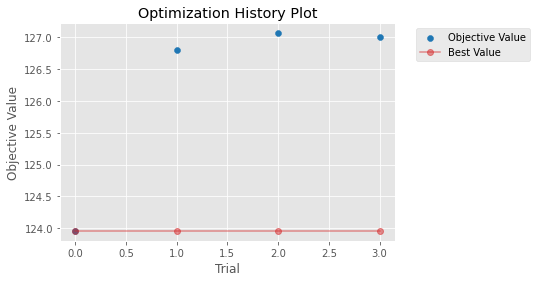

In [60]:
optuna.visualization.matplotlib.plot_optimization_history(study);

##### Step 2: Tune max_depth and min_child_weight


In [69]:
# old_params = study.best_params
old_params1 = {'max_depth': 3,
                'min_child_weight': 4,
                'gamma': 0.15,
                'colsample_bytree': 0.85,
                'subsample': 1.0}

In [79]:
def objective2(trial, X, y, cv, scoring, old_params={}):
    params = {
        # 'max_depth': trial.suggest_int('max_depth', 2, 20),
        'min_child_weight':trial.suggest_int('max_depth', 1, 10),
        **old_params,
        # 'reg_alpha':  trial.suggest_float("reg_alpha", 0., 6., step=0.001),
        # 'reg_lambda': trial.suggest_float("reg_lambda", 0., 6., step=0.001),
        # 'learning_rate': trial.suggest_loguniform('learning_rate', 0.0001, 0.1),
        # 'n_estimators': trial.suggest_int("n_estimators", 50, 900, step=25),  
    }
    
    gr_reg = XGBRegressor(**params)
    scores = cross_validate(gr_reg, X, y, cv=cv, scoring=scoring, n_jobs=2)
    rmse = np.sqrt(-scores["test_score"].mean())

    return rmse

In [80]:
%%time

sampler = optuna.samplers.CmaEsSampler(seed=7)

# Create study that minimizes
study = optuna.create_study(direction="minimize", sampler=sampler)

# Pass additional arguments inside another function
func = lambda trial: objective2(trial, X_train, y_train, cv=cv, scoring="neg_mean_squared_error", old_params=old_params1)


study.optimize(func, timeout=60*1, show_progress_bar =True)

# print(f"Base RMSE     : {rmse:.5f}")
print(f"Optimized RMSE: {study.best_value:.5f}")

   0%|          | 00:00/01:00

Optimized RMSE: 120.57545
CPU times: user 1.02 s, sys: 106 ms, total: 1.13 s
Wall time: 1min 1s


### SHAP

In [87]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 575.9/575.9 KB 9.2 MB/s eta 0:00:00


In [88]:
import shap

In [109]:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

Train SHAP plot


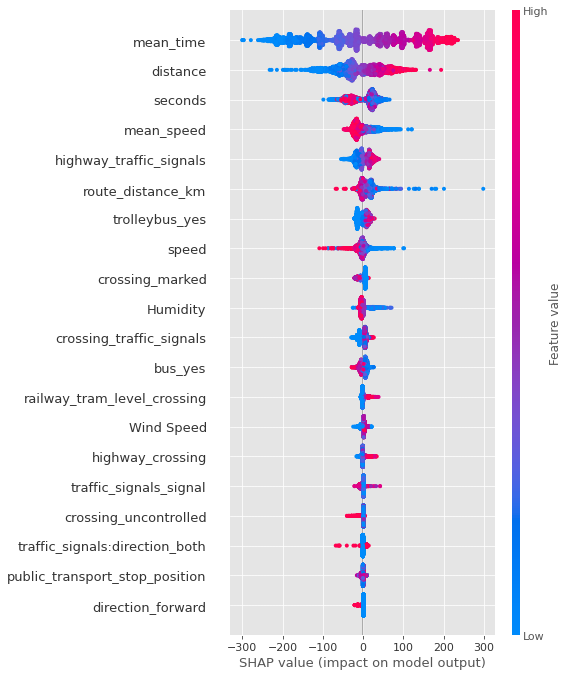

Test SHAP plot


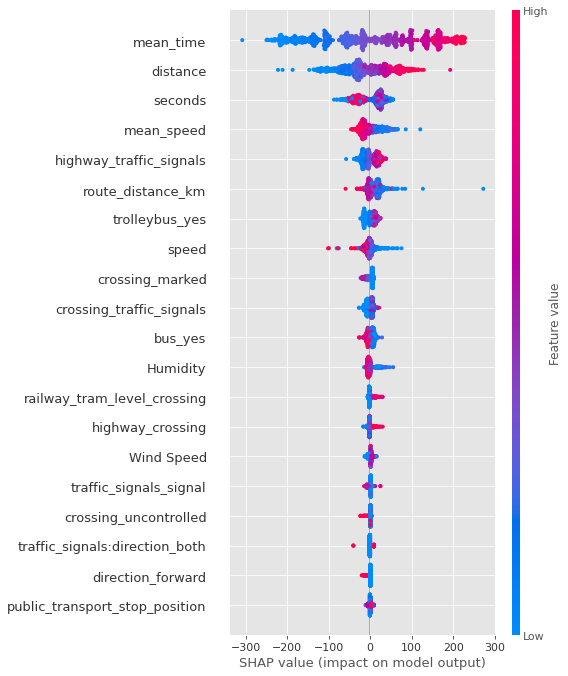

In [112]:
shap.initjs()

params = {'max_depth': 3,
        'min_child_weight': 4,
        'gamma': 0.15,
        'colsample_bytree': 0.85,
        'subsample': 1.0}


model_xgb = XGBRegressor(**params)
model_xgb.fit(X_train_scaled, y_train, verbose=False)

y_pred = model_xgb.predict(X_test)

explainer = shap.TreeExplainer(model_xgb)
shap_values_train = explainer.shap_values(X_train_scaled)
shap_values_test = explainer.shap_values(X_test_scaled)


# visualize 

print('Train SHAP plot')

shap.summary_plot(shap_values_train, X_train_scaled_df)
print('=================================================================')


print('Test SHAP plot')
shap.summary_plot(shap_values_test, X_test_scaled_df)



In [20]:
!pip install pytorch-tabnet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 KB 2.4 MB/s eta 0:00:00


In [21]:
from pytorch_tabnet.tab_model import TabNetRegressor
from sklearn.model_selection import KFold

kf = KFold(n_splits=10, random_state=42, shuffle=True)
predictions_array =[]
CV_score_array    =[]
for train_index, test_index in kf.split(X_train):
    X_tr, X_val = X_train[train_index], X_train[test_index]
    y_tr, y_val = y_train[train_index], y_train[test_index]
    regressor = TabNetRegressor(verbose=0,seed=42)
    regressor.fit(X_train=X_tr, y_train=y_tr,
              eval_set=[(X_val, y_val)],
              patience=300, max_epochs=300,
              eval_metric=['rmse'])
    CV_score_array.append(regressor.best_cost)
    predictions_array.append(np.expm1(regressor.predict(X_val)))

predictions = np.mean(predictions_array,axis=0)

Stop training because you reached max_epochs = 300 with best_epoch = 98 and best_val_0_rmse = 122.31472


/usr/local/lib/python3.8/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
<ipython-input-21-0fdae322d3e4>:16: RuntimeWarning: overflow encountered in expm1
  predictions_array.append(np.expm1(regressor.predict(X_val)))


Stop training because you reached max_epochs = 300 with best_epoch = 88 and best_val_0_rmse = 125.09234


/usr/local/lib/python3.8/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
<ipython-input-21-0fdae322d3e4>:16: RuntimeWarning: overflow encountered in expm1
  predictions_array.append(np.expm1(regressor.predict(X_val)))


Stop training because you reached max_epochs = 300 with best_epoch = 88 and best_val_0_rmse = 123.23113


/usr/local/lib/python3.8/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
<ipython-input-21-0fdae322d3e4>:16: RuntimeWarning: overflow encountered in expm1
  predictions_array.append(np.expm1(regressor.predict(X_val)))


Stop training because you reached max_epochs = 300 with best_epoch = 124 and best_val_0_rmse = 120.99667


/usr/local/lib/python3.8/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
<ipython-input-21-0fdae322d3e4>:16: RuntimeWarning: overflow encountered in expm1
  predictions_array.append(np.expm1(regressor.predict(X_val)))


Stop training because you reached max_epochs = 300 with best_epoch = 102 and best_val_0_rmse = 129.74709


/usr/local/lib/python3.8/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
<ipython-input-21-0fdae322d3e4>:16: RuntimeWarning: overflow encountered in expm1
  predictions_array.append(np.expm1(regressor.predict(X_val)))


KeyboardInterrupt: ignored